## Face Recognition (from Python Data Science Handbook by Jake VanderPlas)

As an example of support vector machines in action, let's take a look at the facial recognition problem.
We will use the Labeled Faces in the Wild dataset, which consists of several thousand collated photos of various public figures.
A fetcher for the dataset is built into Scikit-Learn:

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


In [3]:
# Let's visualize a few sample faces
n_samples, h, w = faces.images.shape  # number of samples, height, width
n_classes = len(faces.target_names)   # number of classes (different people)

Let's plot a few of these faces to see what we're working with:

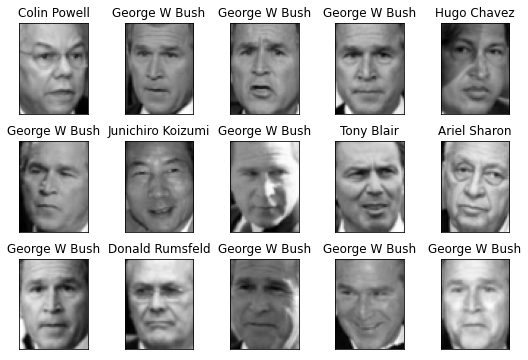

In [4]:
# Create a grid of images to visualize a few faces
fig, axes = plt.subplots(3, 5, figsize=(9, 6), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw={'hspace': 0.3, 'wspace': 0.3})

for i, ax in enumerate(axes.flat):
    ax.imshow(faces.images[i], cmap='gray')
    ax.set_title(faces.target_names[faces.target[i]])
plt.show()

Each image contains [62×47] or nearly 3,000 pixels.
We could proceed by simply using each pixel value as a feature, but often it is more effective to use some sort of preprocessor to extract more meaningful features; here we will use a principal component analysis (we will learn about PCA later) to extract 150 fundamental components to feed into our support vector machine classifier.
We can do this most straightforwardly by packaging the preprocessor and the classifier into a single pipeline:

In [9]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=150, whiten=True, random_state=42)
svm = SVC(kernel='linear', random_state=42)

# Create a pipeline to chain PCA and SVM together
pipeline = make_pipeline(pca, svm)

For the sake of testing our classifier output, we will split the data into a training and testing set:

In [10]:
from sklearn.model_selection import train_test_split

In [12]:
X=faces.data
y=faces.target

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [14]:
pipeline.fit(X_train,y_train)
accuracy=pipeline.score(X_test,y_test)
print(f"Accuracy on test set: {accuracy:.2f}")

Accuracy on test set: 0.76


Finally, we can use a grid search cross-validation to explore combinations of parameters.
Here we will adjust ``C`` (which controls the margin hardness) and ``gamma`` (which controls the size of the radial basis function kernel), and determine the best model:

In [16]:
from sklearn.model_selection import GridSearchCV
# Define the parameter grid for grid search
param_grid = {
    'svc__C': [0.1, 1, 10, 100],  # Regularization parameter for SVM
    'svc__gamma': ['scale', 'auto', 0.01, 0.1, 1],  # Gamma for RBF kernel
}

# Set up GridSearchCV with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters found by grid search
print("Best parameters found by GridSearchCV:", grid_search.best_params_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
accuracy = best_model.score(X_test, y_test)
print(f"Accuracy of the best model on the test set: {accuracy:.2f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found by GridSearchCV: {'svc__C': 0.1, 'svc__gamma': 'scale'}
Accuracy of the best model on the test set: 0.77


The optimal values fall toward the middle of our grid; if they fell at the edges, we would want to expand the grid to make sure we have found the true optimum.

Now with this cross-validated model, we can predict the labels for the test data, which the model has not yet seen:

In [19]:
# Step 1: Use the best model from grid search to make predictions on the test data
y_pred = grid_search.best_estimator_.predict(X_test)

# Step 2: Evaluate performance (accuracy on the test set)
test_accuracy = grid_search.best_estimator_.score(X_test, y_test)
print(f"Test set accuracy: {test_accuracy:.2f}")

Test set accuracy: 0.77


Let's take a look at a few of the test images along with their predicted values:

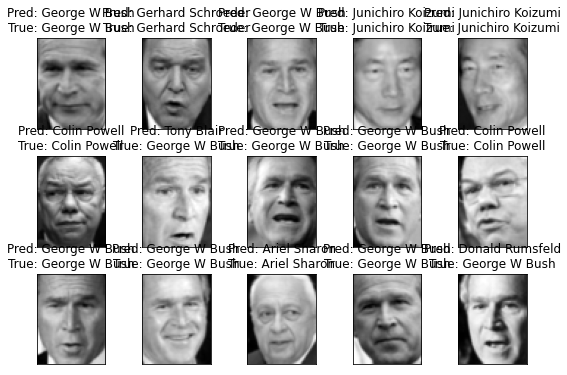

In [20]:
# Create a grid of images to show predictions and true labels
fig, axes = plt.subplots(3, 5, figsize=(9, 6), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw={'hspace': 0.3, 'wspace': 0.3})

# Loop over the axes and plot the test images with their predicted and true labels
for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[i].reshape(h, w), cmap='gray')  # Reshape to 2D image
    predicted_label = faces.target_names[y_pred[i]]
    true_label = faces.target_names[y_test[i]]
    ax.set_title(f"Pred: {predicted_label}\nTrue: {true_label}")

plt.show()

Out of this small sample, our optimal estimator mislabeled only a single face (Bush’s
face in the bottom row was mislabeled as Blair).
We can get a better sense of our estimator's performance using the classification report, which lists recovery statistics label by label:

In [21]:
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(y_test, y_pred, target_names=faces.target_names)

# Print the classification report
print(report)


                   precision    recall  f1-score   support

     Ariel Sharon       0.71      0.71      0.71        17
     Colin Powell       0.77      0.86      0.81        84
  Donald Rumsfeld       0.76      0.78      0.77        36
    George W Bush       0.84      0.78      0.81       146
Gerhard Schroeder       0.56      0.64      0.60        28
      Hugo Chavez       0.94      0.59      0.73        27
Junichiro Koizumi       0.70      0.88      0.78        16
       Tony Blair       0.69      0.71      0.70        51

         accuracy                           0.77       405
        macro avg       0.75      0.74      0.74       405
     weighted avg       0.77      0.77      0.77       405



We might also display the confusion matrix between these classes:

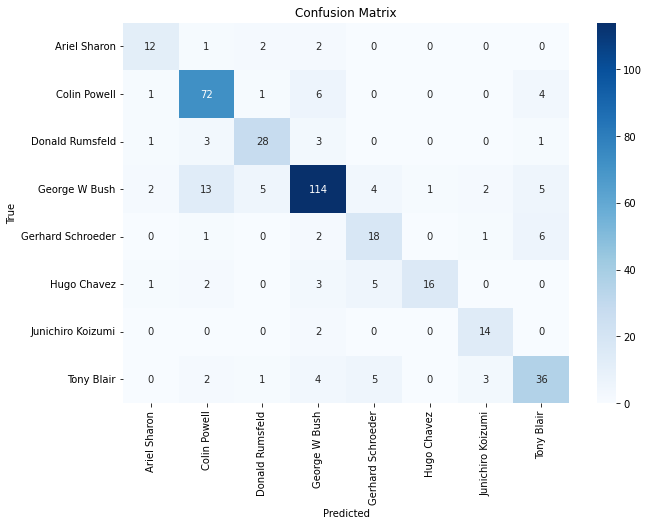

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=faces.target_names, yticklabels=faces.target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

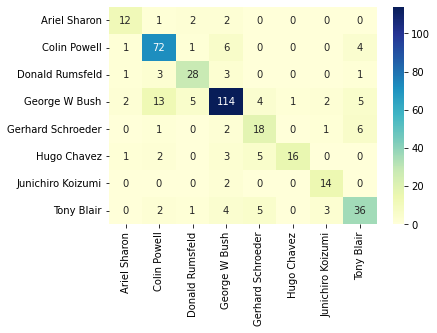

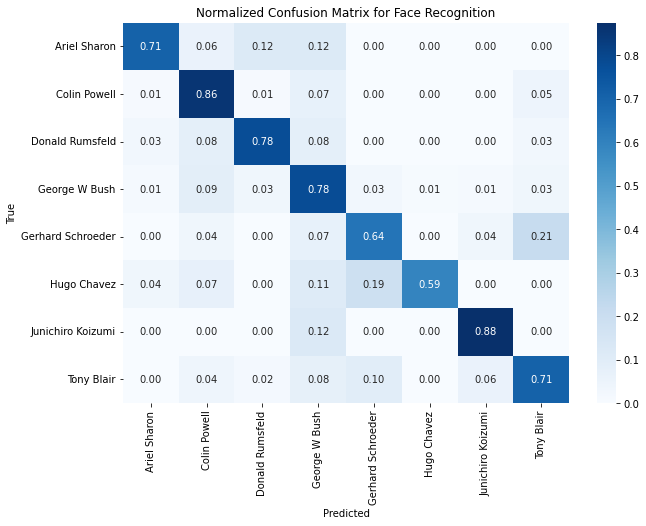

In [23]:
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=faces.target_names, yticklabels=faces.target_names)

# Normalize the confusion matrix to display percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix as a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', xticklabels=faces.target_names, yticklabels=faces.target_names)

# Labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix for Face Recognition')

# Show the plot
plt.show()

This helps us get a sense of which labels are likely to be confused by the estimator.

For a real-world facial recognition task, in which the photos do not come pre-cropped into nice grids, the only difference in the facial classification scheme is the feature selection: you would need to use a more sophisticated algorithm to find the faces, and extract features that are independent of the pixellation.
For this kind of application, one good option is to make use of [OpenCV](http://opencv.org), which, among other things, includes pre-trained implementations of state-of-the-art feature extraction tools for images in general and faces in particular.